### Scimap framework - spatial interaction analysis
Quantify the spatial interactions between cell types by looking at co-localization outside of random chance.

In [1]:
import matplotlib.pyplot as plt
from anndata import AnnData
import anndata as ad
import scimap as sm
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import copy
import os

# read in saved anndata object
data_path = os.path.join('..', 'outputs', 'adata.h5ad')

if os.path.exists(data_path):
    adata = ad.read_h5ad(data_path)
else:
    print(f"File not found. Check path.")

metadata = ['Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'Leiden', 'phenotype', 'Timepoint']
markers = ['DAPI', 'CD44', 'HLA-DR', 'CD4', 'IFNG', 'Ki67', 'CD107a', 'CD45', 'CD20', 'CD40', 'CD8', 'Pan-Cytokeratin', 'CD68', 'HLA-A', 'CD79a', 'CD45RO', 'CD21', 'CD11c', 'HLA-E', 'IDO1', 'CD14', 'CD56', 'VISTA', 'FOXP3', 'Granzyme B', 'PCNA', 'T-bet/TBX21', 'PD-L1', 'TOX', 'PD-1', 'CD38', 'ICOS', 'CD39', 'LAG3', 'TCF-1', 'CD3e']

Running SCIMAP  2.1.3


In [2]:
# sample 50% of the indices
sampled_indices = adata.obs.sample(frac=0.25, random_state=42).index
adata = adata[sampled_indices].copy()

# make a pre DLN adata object and a post DLN one so can plot them separately
pre = adata.obs['Timepoint'] == 'DLN pre'
adata_pre = adata[pre].copy()
post = adata.obs['Timepoint'] == 'DLN post'
adata_post = adata[post].copy()
print(adata_pre)

AnnData object with n_obs × n_vars = 515692 × 36
    obs: 'Image', 'Object ID', 'Classification', 'Parent', 'Centroid X µm', 'Centroid Y µm', 'Leiden', 'phenotype', 'Timepoint'


In [3]:
# pre interactions between cell types
adata_pre = sm.tl.spatial_interaction (adata_pre, 
                                   x_coordinate='Centroid X µm',
                                   y_coordinate='Centroid Y µm',
                                   method='radius', 
                                   imageid='Parent',
                                   radius=100, 
                                   permutation=100,
                                   label='spatial_interaction_radius')

Processing Image: ['Slide 11 B1']
Categories (1, object): ['Slide 11 B1']
Identifying neighbours within 100 pixels of every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['Slide 11 A1']
Categories (1, object): ['Slide 11 A1']
Identifying neighbours within 100 pixels of every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['Slide 9 B2']
Categories (1, object): ['Slide 9 B2']
Identifying neighbours within 100 pixels of every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['Slide 9 A1']
Categories (1, object): ['Slide 9 A1']
Identifying neighbours within 100 pixels of every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['Slide 11 A1-1']
Categories (1, object): ['Slide 11 A1-1']
Identifying neighbours

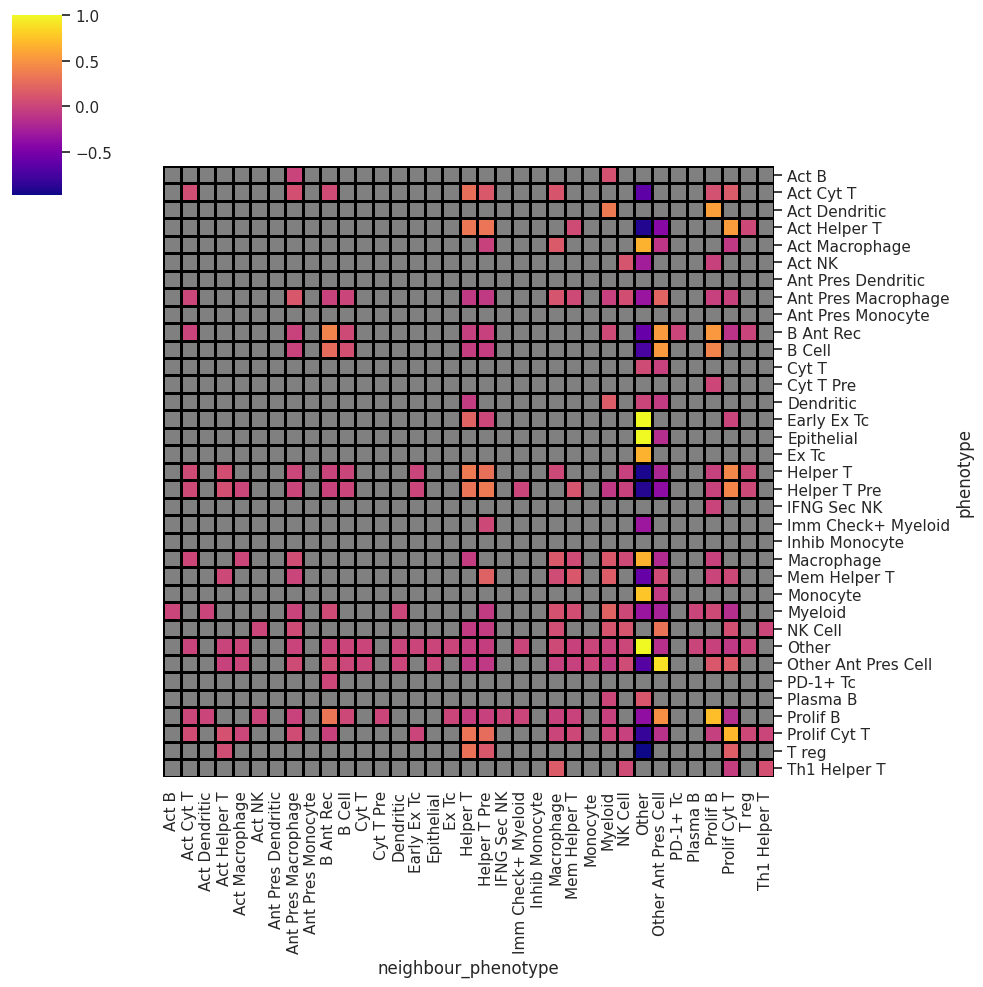

In [4]:
# pre interaction heatmap
sm.pl.spatial_interaction(adata_pre, 
                          spatial_interaction='spatial_interaction_radius',
                          p_val=0.01, cmap='plasma',
                        #   row_cluster=True, col_cluster=True,
                          linewidths=0.75, linecolor='black')

In [5]:
# post interactions between cell types
adata_post = sm.tl.spatial_interaction (adata_post, 
                                   x_coordinate='Centroid X µm',
                                   y_coordinate='Centroid Y µm',
                                   method='radius', 
                                   imageid='Parent',
                                   radius=100, 
                                   permutation=100,
                                   label='spatial_interaction_radius')

Processing Image: ['Slide 12 C1-1']
Categories (1, object): ['Slide 12 C1-1']
Identifying neighbours within 100 pixels of every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['Slide 12 E1']
Categories (1, object): ['Slide 12 E1']
Identifying neighbours within 100 pixels of every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['Slide 10 D1']
Categories (1, object): ['Slide 10 D1']
Identifying neighbours within 100 pixels of every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['Slide 12 C1']
Categories (1, object): ['Slide 12 C1']
Identifying neighbours within 100 pixels of every cell
Mapping phenotype to neighbors
Performing 100 permutations
Consolidating the permutation results
Processing Image: ['Slide 10 C1']
Categories (1, object): ['Slide 10 C1']
Identifying neighb

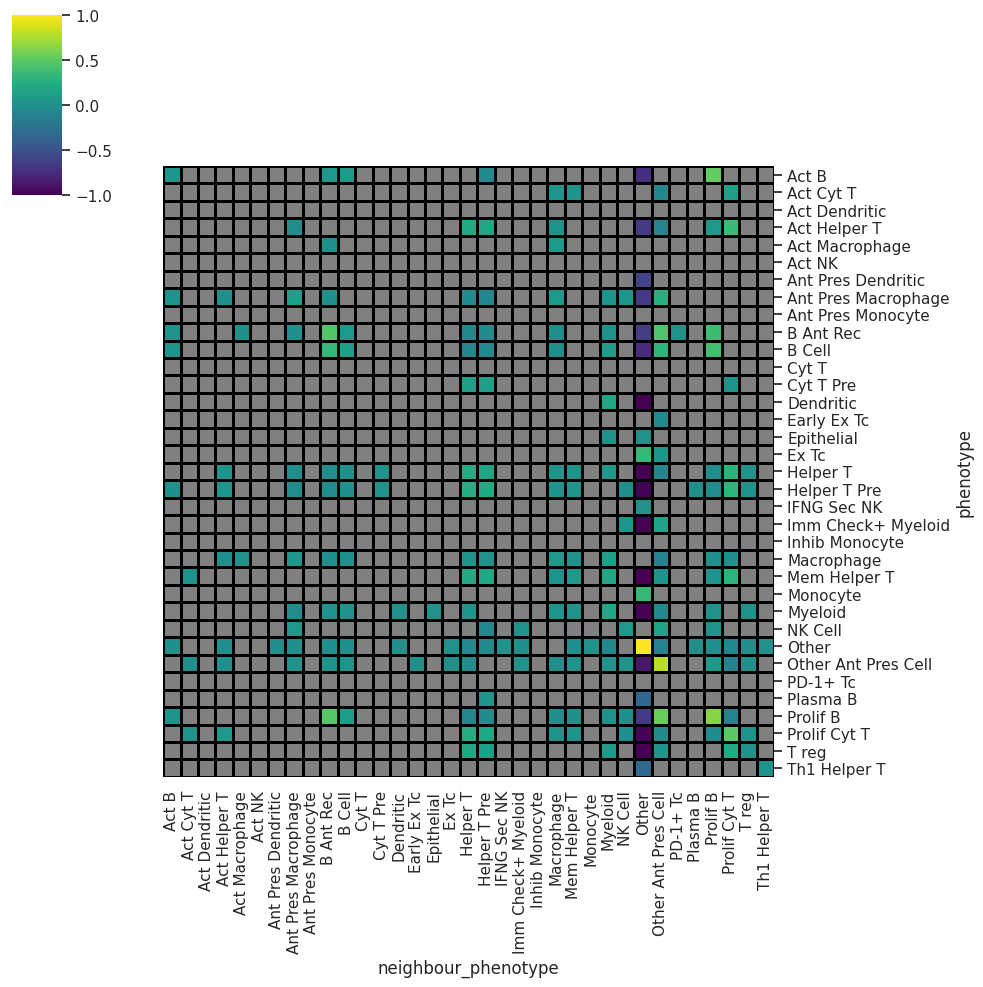

In [6]:
# post interaction heatmap
sm.pl.spatial_interaction(adata_post, 
                          spatial_interaction='spatial_interaction_radius',
                          p_val=0.01, cmap='viridis',
                        #   row_cluster=True, col_cluster=True,
                          linewidths=0.75, linecolor='black')

### Proximity volume and density
- Proximity volume = number of interactions to total cells in dataset
- Proximity density = number of interactions to number of cells in interacting types (interactions relative to pop size)

In [7]:
print(adata_pre.obs['phenotype'].unique())

['Helper T', 'Ant Pres Macrophage', 'Myeloid', 'Other', 'Cyt T', ..., 'Epithelial', 'Act Dendritic', 'Inhib Monocyte', 'PD-1+ Tc', 'Plasma B']
Length: 36
Categories (35, object): ['Act B', 'Act Cyt T', 'Act Dendritic', 'Act Helper T', ..., 'Prolif B', 'Prolif Cyt T', 'T reg', 'Th1 Helper T']


Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Please check:
adata.obs['spatial_pscore_Ant Pres Macrophage-Plasma B'] &
adata.uns['spatial_pscore_Ant Pres Macrophage-Plasma B'] for results


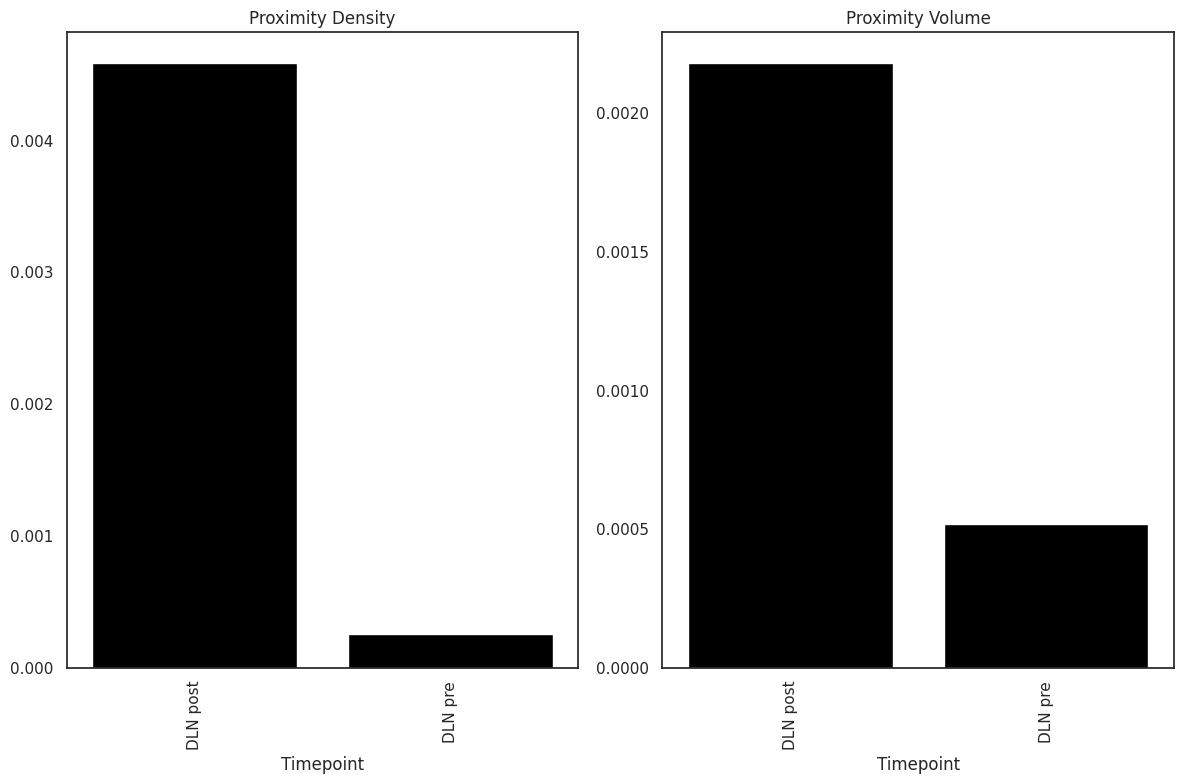

Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Please check:
adata.obs['spatial_pscore_Inhib Monocyte-Th1 Helper T'] &
adata.uns['spatial_pscore_Inhib Monocyte-Th1 Helper T'] for results


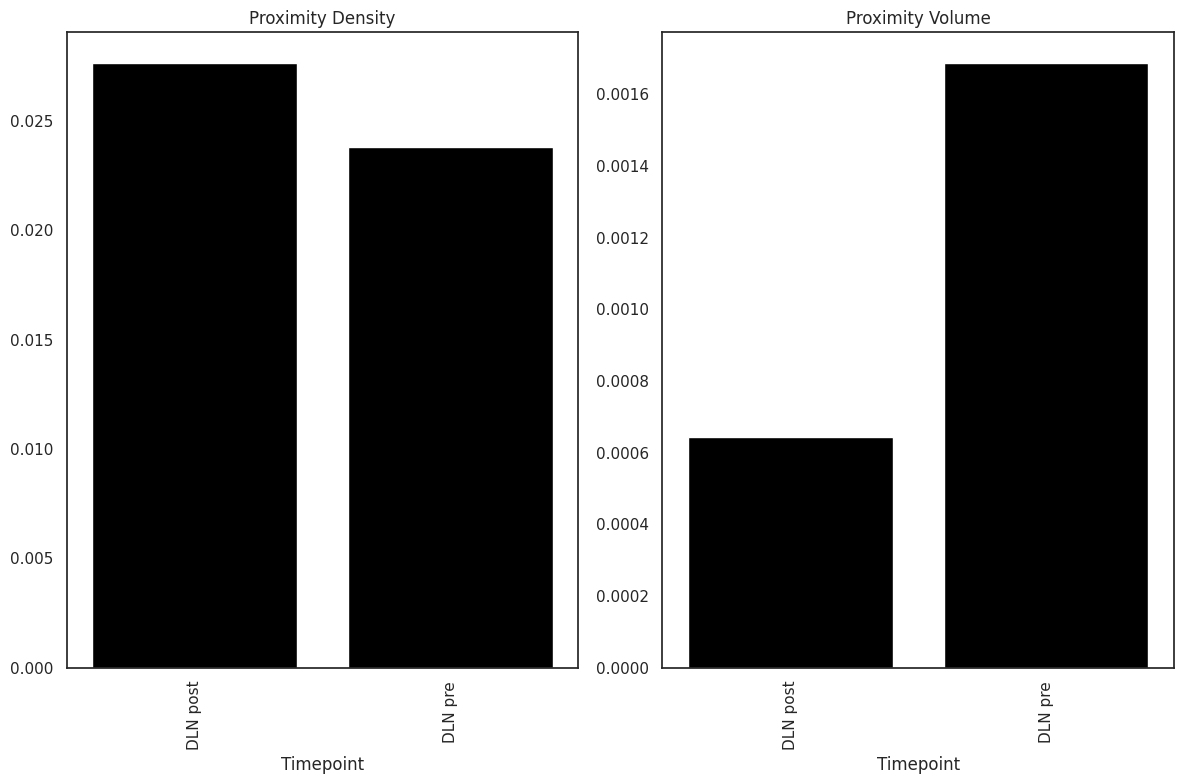

Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Please check:
adata.obs['spatial_pscore_Act Macrophage-Prolif Cyt T'] &
adata.uns['spatial_pscore_Act Macrophage-Prolif Cyt T'] for results


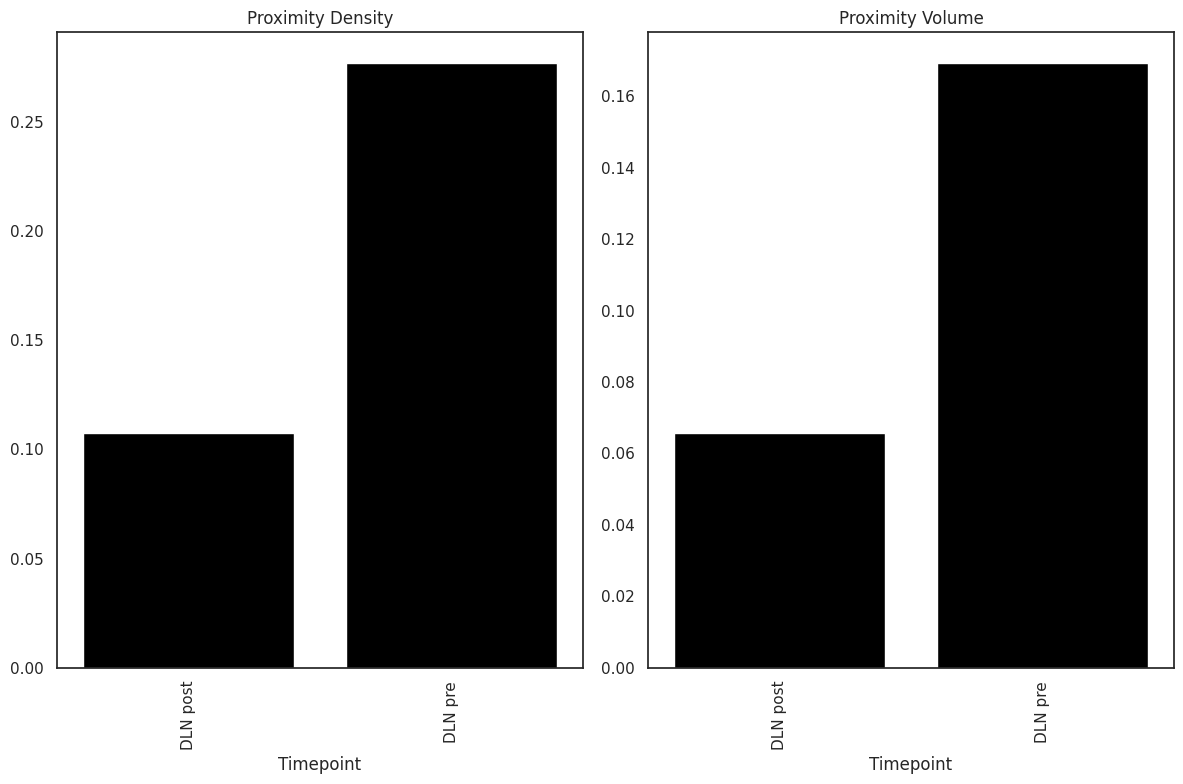

Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Identifying neighbours within 100 pixels of every cell
Please check:
adata.obs['spatial_pscore_T reg-Plasma B'] &
adata.uns['spatial_pscore_T reg-Plasma B'] for results


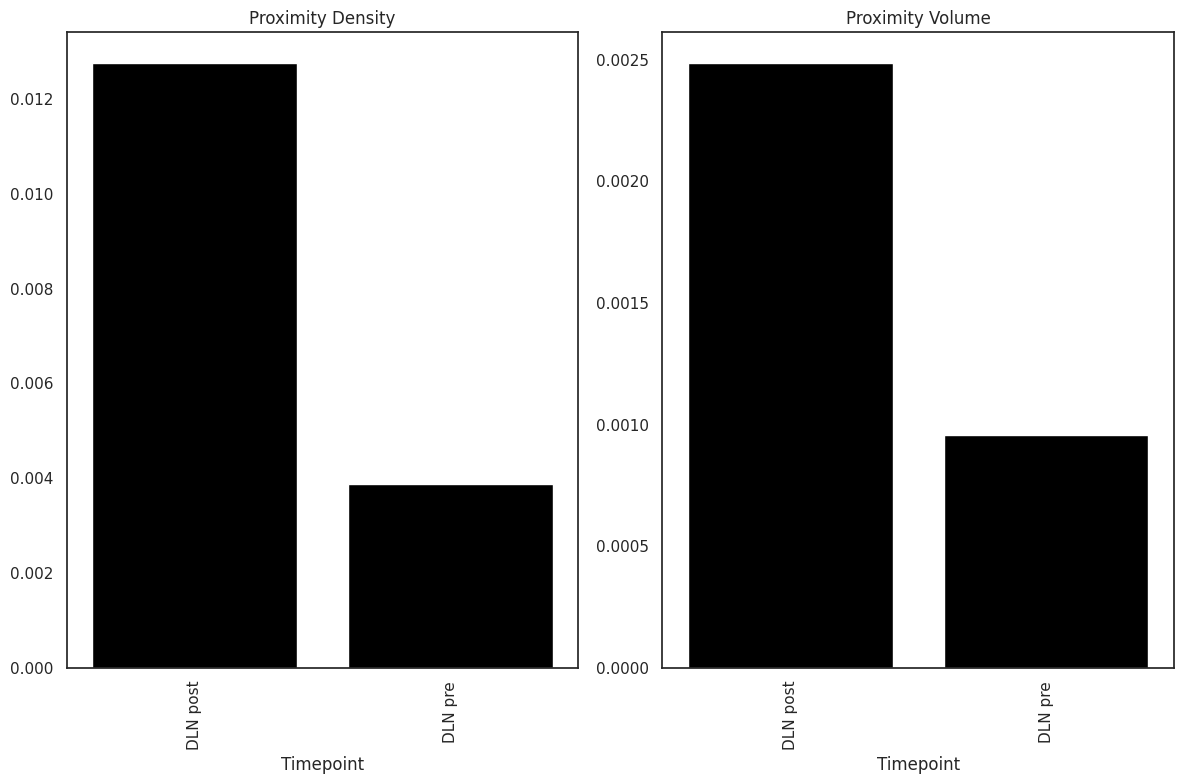

In [8]:
# spatial pscore
interactions_oi = [('Ant Pres Macrophage' , 'Plasma B'), ('Inhib Monocyte', 'Th1 Helper T'), ('Act Macrophage', 'Prolif Cyt T'), ('T reg', 'Plasma B')]
for interaction in interactions_oi:
    adata =  sm.tl.spatial_pscore (adata,
                                   imageid='Parent',
                                   x_coordinate='Centroid X µm',
                                   y_coordinate='Centroid Y µm',
                                   proximity= [interaction[0], interaction[1]],
                                   score_by = 'Timepoint',
                                   phenotype='phenotype',
                                   method='radius',
                                   label=f'spatial_pscore_{interaction[0]}-{interaction[1]}',
                                   radius=100)
    sm.pl.spatial_pscore (adata, color='black', label=f'spatial_pscore_{interaction[0]}-{interaction[1]}', figsize=(12,8))

Slide 12 C1-1
spatial_pscore_Ant Pres Macrophage-Plasma B


KeyboardInterrupt: 

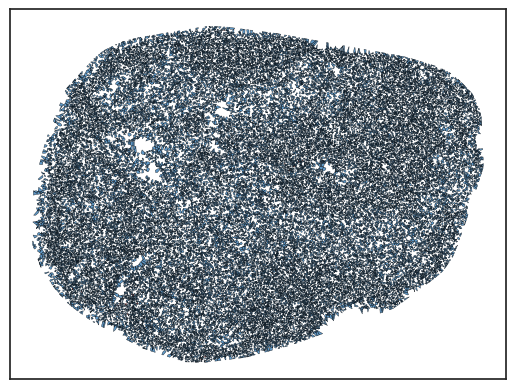

In [9]:
# voronoi plots to visualize the spatial pscore within the tissue - red is region of interaction
d = adata.obs
for interaction in interactions_oi:
    for parent in d['Parent'].unique():
        a = d[d['Parent'] == parent]
        if (interaction[0] in a['phenotype'].unique()) and (interaction[1] in a['phenotype'].unique()):
            print(parent)
            print(f'spatial_pscore_{interaction[0]}-{interaction[1]}')
            sm.pl.voronoi(adata, 
                            imageid='Parent',
                            x_coordinate='Centroid X µm',
                            y_coordinate='Centroid Y µm',
                            flip_y=False,
                            subset=parent,
                            color_by=f'spatial_pscore_{interaction[0]}-{interaction[1]}', 
                            voronoi_edge_color = 'black',
                            size_max=3000,
                            voronoi_line_width = 0.3, 
                            voronoi_alpha = 0.8, 
                            overlay_points=None, 
                            plot_legend=True, 
                            legend_size=6,
                            )

### Identify regions of aggregation
Identify spatial clusters of cells with similar phenotypes throughout tissue - purity is the minimum percentage of similarity required among cells 

In [ ]:
adata = sm.tl.spatial_aggregate(adata, 
                                x_coordinate='Centroid X µm', 
                                y_coordinate='Centroid Y µm', 
                                imageid='Parent', 
                                method='radius', 
                                radius=200, 
                                purity=80, 
                                label='spatial_aggregate_radius')

In [ ]:
adata.obs.head()

In [ ]:
d = adata.obs
all_parents = d['Parent'].unique()
for parent in all_parents:
    ncells = len(d[d['Parent'] == parent].index)
    print(parent)
    sm.pl.voronoi(adata, 
                    imageid='Parent',
                    x_coordinate='Centroid X µm',
                    y_coordinate='Centroid Y µm',
                    flip_y=False,
                    subset=parent,
                    color_by='spatial_aggregate_radius', 
                    voronoi_edge_color = 'black',
                    voronoi_line_width = 0.3, 
                    voronoi_alpha = 0.8, 
                    size_max=3000,
                    overlay_points=None, 
                    plot_legend=True, 
                    legend_size=6)

In [ ]:
sp = os.path.join('..', 'outputs', 'adata2.h5ad')
sp2 = os.path.join('..', 'outputs', 'adata_pre.h5ad')
sp3 = os.path.join('..', 'outputs', 'adata_post.h5ad')

adata.write(sp)
adata_pre.write(sp2)
adata_post.write(sp3)